In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from keras import models
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [129]:
# Step 1: Collect Stock Data
ticker = 'AAPL'
apple = yf.Ticker("AAPL")
df = yf.download(ticker, start='2014-01-01', end='2024-06-10')
df.sort_values('Date', inplace=True, ascending=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.273226,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.893803,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.985928,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.864445,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.971254,258529600


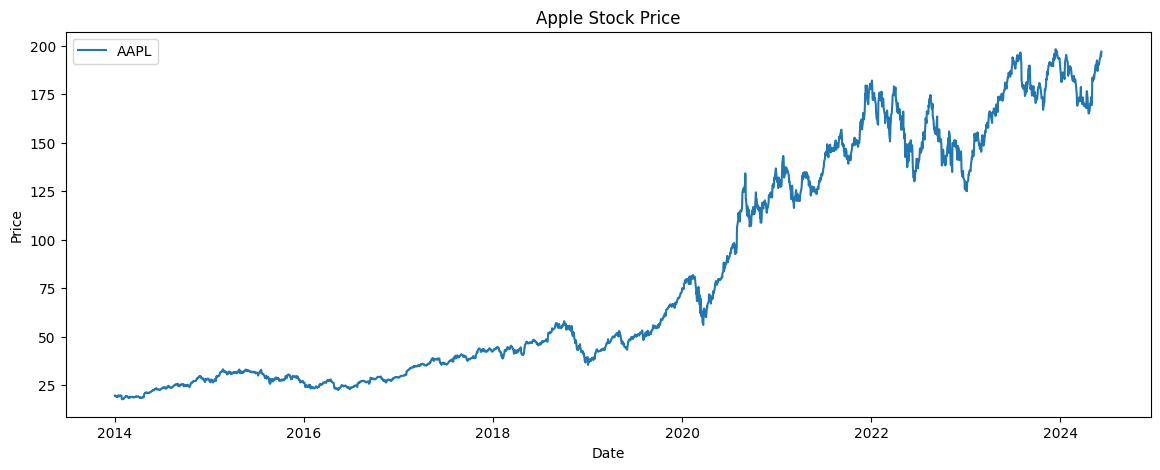

In [130]:
plt.figure(figsize=(14, 5))
plt.plot(df['Close'], label='AAPL')
plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [131]:
high_prices = df.loc[:, 'High'].values
low_prices = df.loc[:, 'Low'].values
mid_prices = (high_prices + low_prices) / 2.0

In [132]:
train_data = mid_prices[:2000]
test_data = mid_prices[2000:]

In [133]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

In [134]:
smoothing_window_size = 250
for di in range(0, 2000, smoothing_window_size):
    scaler.fit(train_data[di:di + smoothing_window_size, :])
    train_data[di:di + smoothing_window_size, :] = scaler.transform(train_data[di:di + smoothing_window_size, :])

In [135]:
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [136]:
EMA = 0.0
gamma = 0.1
for ti in range(2000):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA
    
all_mid_data = np.concatenate([train_data, test_data], axis=0)

In [137]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
    
for pred_idx in range(window_size, N):
    
        if pred_idx >= N:
            date = pd.to_datetime(df.iloc[pred_idx].name)
        else:
            date = pd.to_datetime(df.iloc[pred_idx - 1].name)
            
        std_avg_predictions.append(np.mean(train_data[pred_idx - window_size:pred_idx]))
        mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)
        std_avg_x.append(date)

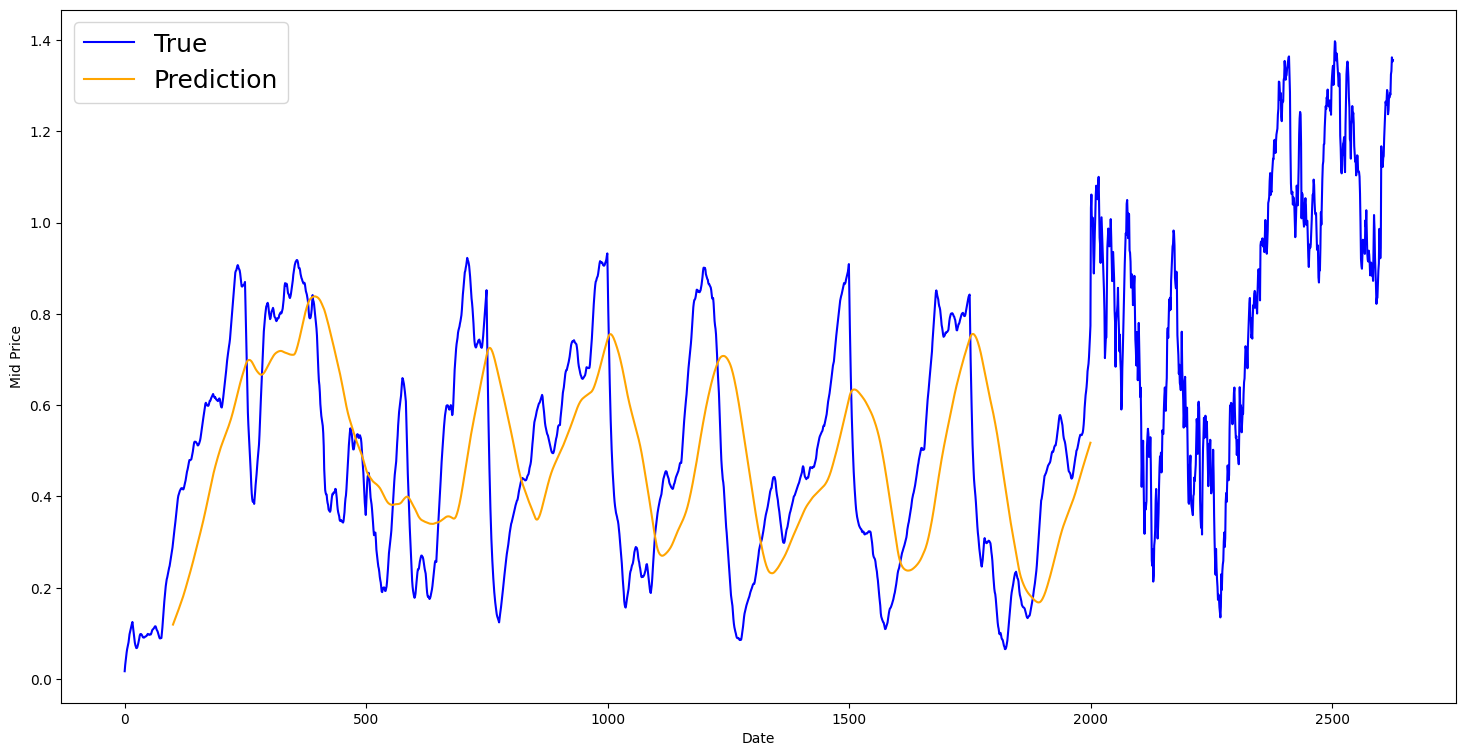

In [138]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [139]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1, N):
        
        running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
        run_avg_predictions.append(running_mean)
        mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
        run_avg_x.append(date)
print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00025


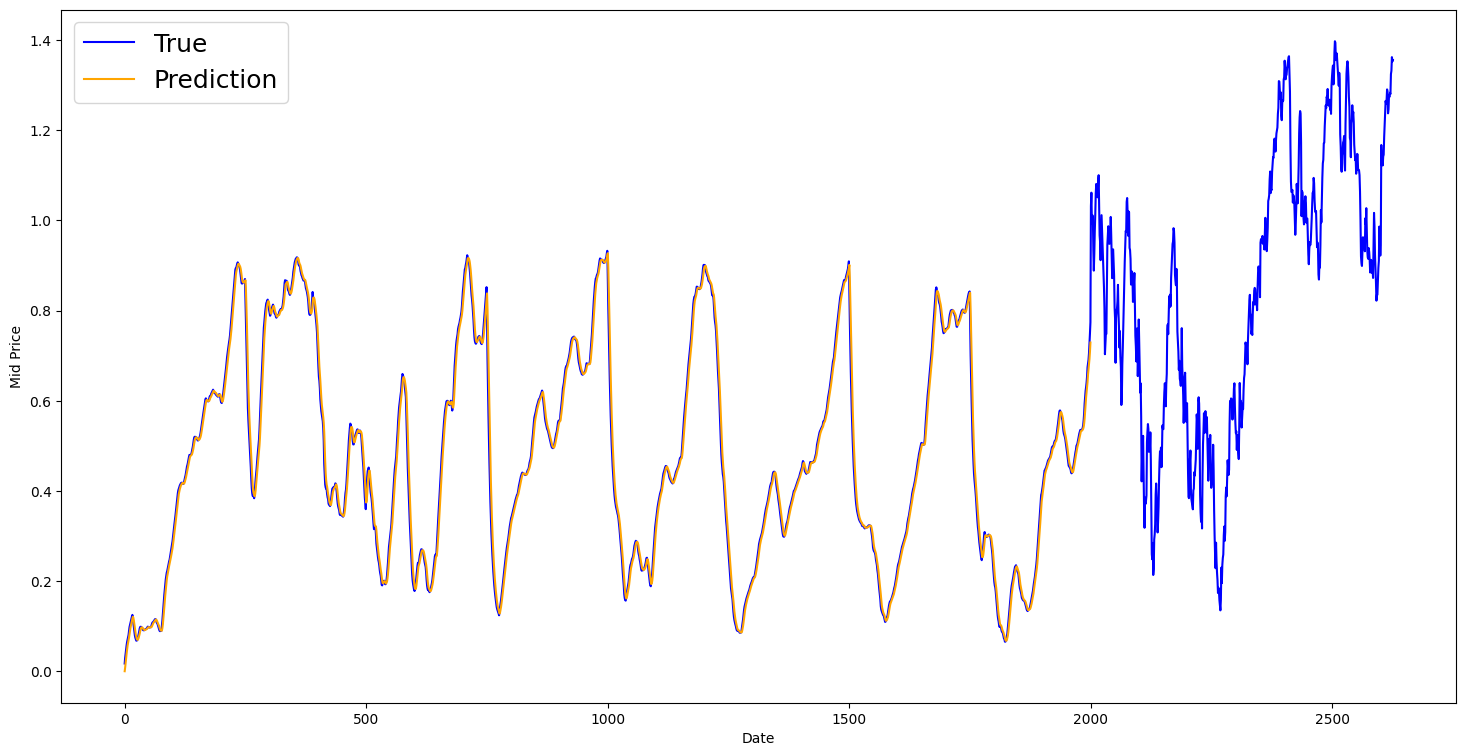

In [140]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Implementing an LSTM model


In [141]:
def create_sequences(data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps)]
        Xs.append(v)
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

In [142]:
time_steps = 30
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

In [143]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [144]:
model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/Users/kryptos/PycharmProjects/Porject ML/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [145]:
history = model.fit(X_train, y_train, epochs=250, batch_size=32 , validation_data=(X_test, y_test), shuffle=False)

Epoch 1/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0320 - val_loss: 0.0163
Epoch 2/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 3/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 4/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0076
Epoch 5/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 6/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 7/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0070
Epoch 8/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 9/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 10/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 11/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 12/250
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

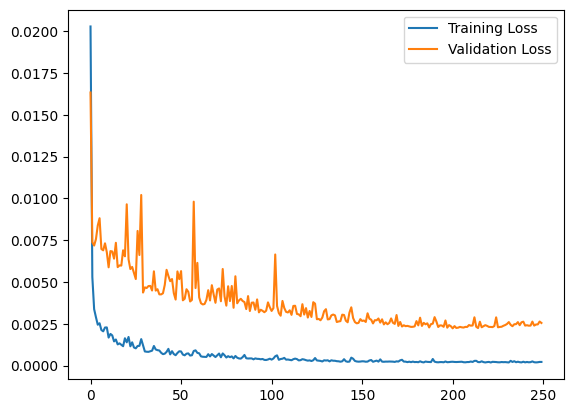

In [146]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [147]:
y_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


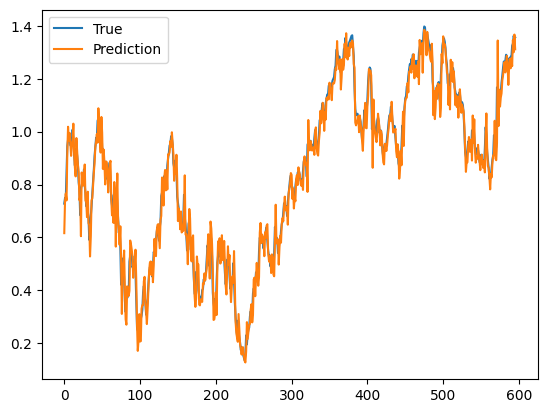

In [148]:
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()

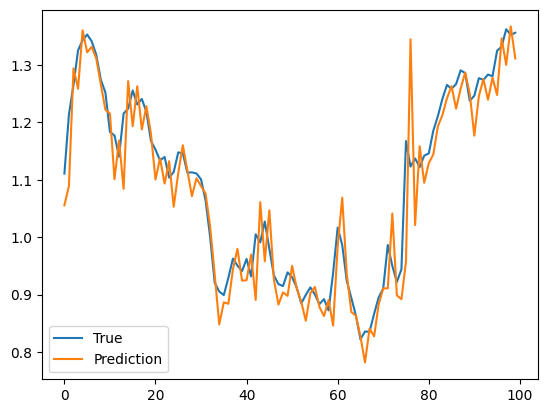

In [149]:
plt.plot(y_test[-100:], label='True')
plt.plot(y_pred[-100:], label='Prediction')
plt.legend()

Calculing accuracy

In [150]:
def accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) < 0.01)

In [151]:
accuracy(y_test, y_pred)

0.018504234043511553

In [152]:
last_sequence = df['Close'][-time_steps:].values.reshape(-1, 1)
last_sequence_scaled = scaler.transform(last_sequence)
X_last = np.array([last_sequence_scaled])
next_day_prediction = model.predict(X_last)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"Predicted stock price for the next day: {next_day_prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted stock price for the next day: 198.3290252685547


In [158]:
#model.save('stock_prediction_good.keras')


In [159]:
#evaluate the model
acc  = model.evaluate(X_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Restored model, accuracy:  0.26%


In [160]:
print(X_train.shape[1], X_train.shape[2])


30 1


In [161]:
model.load_weights('stock_prediction_good.h5')

In [162]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

In [163]:
model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0.6154503 ],
       [0.7611509 ],
       [0.7653718 ],
       [0.7540193 ],
       [0.93578506],
       [1.0218923 ],
       [0.9909965 ],
       [1.000818  ],
       [0.97101116],
       [0.9282862 ],
       [0.95780814],
       [0.9836845 ],
       [1.049506  ],
       [0.93209875],
       [0.8739916 ],
       [0.8381241 ],
       [1.0005754 ],
       [0.9345096 ],
       [0.89195216],
       [0.8474053 ],
       [0.7498679 ],
       [0.7691551 ],
       [0.599923  ],
       [0.8859826 ],
       [0.7990945 ],
       [0.82032484],
       [0.8319081 ],
       [0.8895119 ],
       [0.74707544],
       [0.7418753 ],
       [0.6787797 ],
       [0.79737   ],
       [0.6469023 ],
       [0.65883005],
       [0.51612365],
       [0.6264337 ],
       [0.7514868 ],
       [0.74938357],
       [0.8138418 ],
       [0.8477737 ],
       [0.89550614],
       [0.95650953],
       [0.9749094 ],
       [1.0072572 ],
       [0.97196364],
       [1.1062709 ],
       [1.0519633 ],
       [0.993

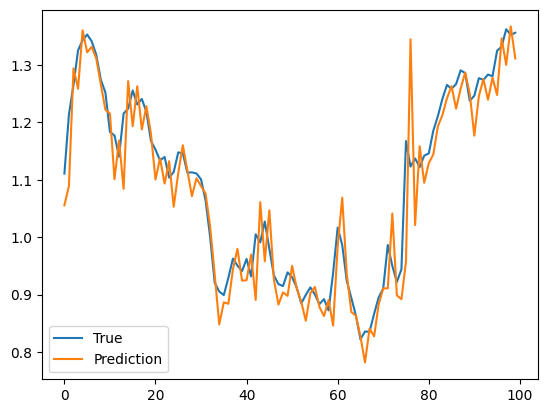

In [164]:
plt.plot(y_test[-100:], label='True')
plt.plot(y_pred[-100:], label='Prediction')
plt.legend()

In [166]:
acc = model.evaluate(X_test, y_test)
print(acc)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
0.002610214054584503
Restored model, accuracy:  0.26%
